In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from datetime import datetime, timedelta

In [ ]:
dataset = pd.read_csv("./csv/bank_loan.csv")
dataset.head()

,Unnamed: 0,Loan_Amount,Interest_Rate,Loan_Term,Applicant_Income,Coapplicant_Income,Credit_Score,Property_Area,Employment_Years,Debt_to_Income_Ratio,Collateral_Value,Application_Date,Loan_Type
0,0,40783.70,6.08%,30,814.02,1248.69,300.0,10902.57,2,35.73,55691.22,2024-02-11,Home Loan
1,1,15165.57,11.51%,13,3095.34,1598.31,300.0,3820.61,9,0.93,19517.17,2019-03-03,Agricultural Loan
2,2,1079.69,11.28%,30,4098.08,2912.64,300.0,8917.89,5,15.33,1603.03,2019-03-13,Agricultural Loan
3,3,26251.79,6.49%,30,11951.28,5777.49,300.0,2557.26,8,90.11,33624.00,2021-07-04,Personal Loan
4,4,17577.19,10.05%,26,2669.93,3000.20,300.0,3241.00,9,15.52,25586.92,2024-01-30,Agricultural Loan


In [ ]:
dataset.columns

Index(['Unnamed: 0', 'Loan_Amount', 'Interest_Rate', 'Loan_Term',
       'Applicant_Income', 'Coapplicant_Income', 'Credit_Score',
       'Property_Area', 'Employment_Years', 'Debt_to_Income_Ratio',
       'Collateral_Value', 'Application_Date', 'Loan_Type'],
      dtype='object')

In [ ]:
dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# Step 2: Data Scaling
# Scaling the features to make them have zero mean and unit variance.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(
    dataset[
        [
            "Loan_Amount",
            "Loan_Term",
            "Applicant_Income",
            "Coapplicant_Income",
            "Credit_Score",
            "Property_Area",
            "Employment_Years",
            "Debt_to_Income_Ratio",
            "Collateral_Value",
        ]
    ]
)

In [ ]:
# Step 3: Determining Optimal Number of Clusters (Elbow Method)
inertia_values = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

In [ ]:
inertia_values

[7999.999999999998,
 6274.814537770247,
 5264.317830696159,
 4597.563145155193,
 4329.654513888983,
 4047.654646474757,
 3737.8501889183194,
 3596.6176567425136,
 3494.2716866771116,
 3402.6764006711483]

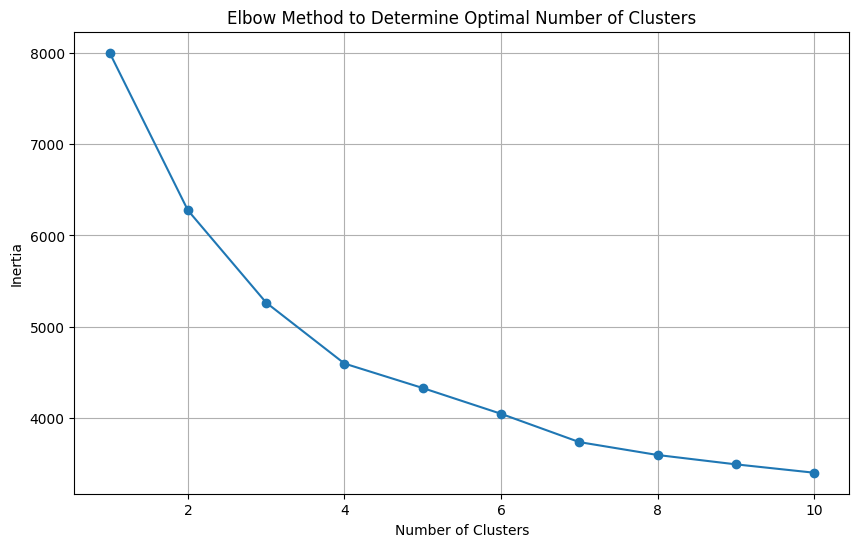

In [ ]:
# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_values, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method to Determine Optimal Number of Clusters")
plt.grid(True)
plt.show()

In [ ]:
# Step 4: Choosing the Number of Clusters Based on Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

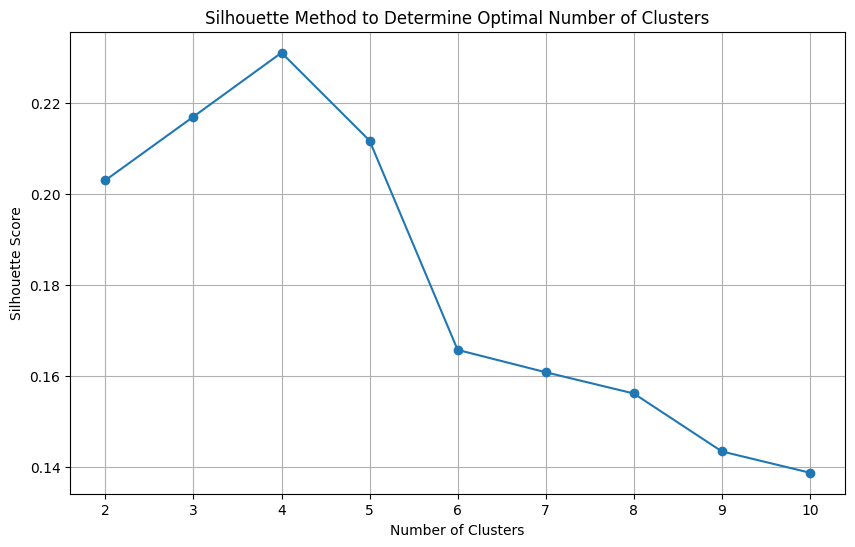

In [ ]:
# Plotting Silhouette Scores for Different Values of K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method to Determine Optimal Number of Clusters")
plt.grid(True)
plt.show()

In [ ]:
# From both the Elbow and Silhouette methods, we will pick K=5

# Step 5: Applying KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the original dataset
dataset["Cluster"] = cluster_labels

In [ ]:
# Add the cluster labels to the original dataset
cluster_names = {
    0: "Low Risk Home Loans",
    1: "High Income Auto Loans",
    2: "Moderate Risk Personal Loans",
    3: "Education Loans with Coapplicant",
    4: "Agricultural Loans with High Collateral",
}
dataset["Cluster"] = pd.Series(cluster_labels).replace(cluster_names)

In [ ]:
# Step 6: Visualizing the Clusters (Using PCA to Reduce Dimensions to 2D)
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
dataset["PCA1"] = pca_data[:, 0]
dataset["PCA2"] = pca_data[:, 1]

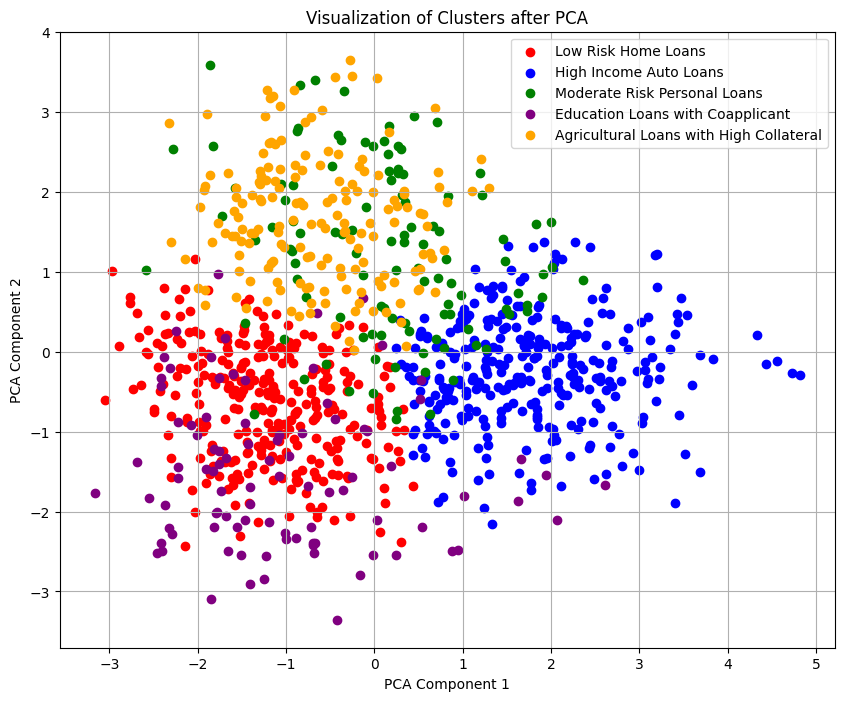

In [ ]:
# Plotting the clusters in the 2D PCA space
plt.figure(figsize=(10, 8))
colors = ["red", "blue", "green", "purple", "orange"]
for cluster_name, color in zip(cluster_names.values(), colors):
    cluster_data = dataset[dataset["Cluster"] == cluster_name]
    plt.scatter(
        cluster_data["PCA1"], cluster_data["PCA2"], color=color, label=cluster_name
    )


plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualization of Clusters after PCA")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 7: Evaluating the Model
# Calculating the Silhouette Score for the chosen K
final_silhouette_score = silhouette_score(scaled_data, cluster_labels)
print(f"Silhouette Score for K=5: {final_silhouette_score:.2f}")

Silhouette Score for K=5: 0.21


In [ ]:
# Step 8: Output the Data Segregation Summary Table
cluster_summary = dataset.groupby("Cluster").size().reset_index(name="Count")
print(cluster_summary)

                                   Cluster  Count
0  Agricultural Loans with High Collateral    170
1         Education Loans with Coapplicant     93
2                   High Income Auto Loans    320
3                      Low Risk Home Loans    307
4             Moderate Risk Personal Loans    110


In [ ]:
# Step 9: Output the Data Segregation Summary Table
cluster_summary = (
    dataset[["Loan_Type", "Cluster"]]
    .groupby("Cluster")
    .size()
    .reset_index(name="Count")
)
cluster_summary["Default_Loan"] = dataset["Loan_Type"]
print(cluster_summary)

                                   Cluster  Count       Default_Loan
0  Agricultural Loans with High Collateral    170          Home Loan
1         Education Loans with Coapplicant     93  Agricultural Loan
2                   High Income Auto Loans    320  Agricultural Loan
3                      Low Risk Home Loans    307      Personal Loan
4             Moderate Risk Personal Loans    110  Agricultural Loan


In [ ]:
# Creating new features
dataset["Loan_to_Income_Ratio"] = dataset["Loan_Amount"] / (
    dataset["Applicant_Income"] + 1
)
dataset["Collateral_Coverage"] = dataset["Collateral_Value"] / (
    dataset["Loan_Amount"] + 1
)
dataset["Property_to_Income_Ratio"] = dataset["Property_Area"] / (
    dataset["Applicant_Income"] + 1
)

# Creating binned features
bins = [300, 580, 670, 740, 850]
labels = ["Poor", "Average", "Good", "Excellent"]
dataset["Credit_Category"] = pd.cut(dataset["Credit_Score"], bins=bins, labels=labels)

# Log transformation to reduce skewness
dataset["Log_Loan_Amount"] = np.log1p(dataset["Loan_Amount"])

# Adding interaction terms
dataset["Loan_Amount_Interest"] = (
    dataset["Loan_Amount"]
    * dataset["Interest_Rate"].str.rstrip("%").astype("float")
    / 100
)

# Feature extraction from date
dataset["Application_Age_Days"] = (
    datetime.now() - pd.to_datetime(dataset["Application_Date"])
).dt.days

In [ ]:
# Display the first few rows of the dataset
print(dataset.head())

   Loan_Amount Interest_Rate  Loan_Term  Applicant_Income  Coapplicant_Income  \
0     40783.70         6.08%         30            814.02             1248.69   
1     15165.57        11.51%         13           3095.34             1598.31   
2      1079.69        11.28%         30           4098.08             2912.64   
3     26251.79         6.49%         30          11951.28             5777.49   
4     17577.19        10.05%         26           2669.93             3000.20   

   Credit_Score  Property_Area  Employment_Years  Debt_to_Income_Ratio  \
0         300.0       10902.57                 2                 35.73   
1         300.0        3820.61                 9                  0.93   
2         300.0        8917.89                 5                 15.33   
3         300.0        2557.26                 8                 90.11   
4         300.0        3241.00                 9                 15.52   

   Collateral_Value  ...                           Cluster      PCA1

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(
    dataset[
        [
            "Loan_Amount",
            "Loan_Term",
            "Applicant_Income",
            "Coapplicant_Income",
            "Credit_Score",
            "Property_Area",
            "Employment_Years",
            "Debt_to_Income_Ratio",
            "Collateral_Value",
            "Loan_to_Income_Ratio",
            "Collateral_Coverage",
            "Property_to_Income_Ratio",
            "Log_Loan_Amount",
            "Loan_Amount_Interest",
            "Application_Age_Days",
        ]
    ]
)

In [ ]:
inertia_values = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

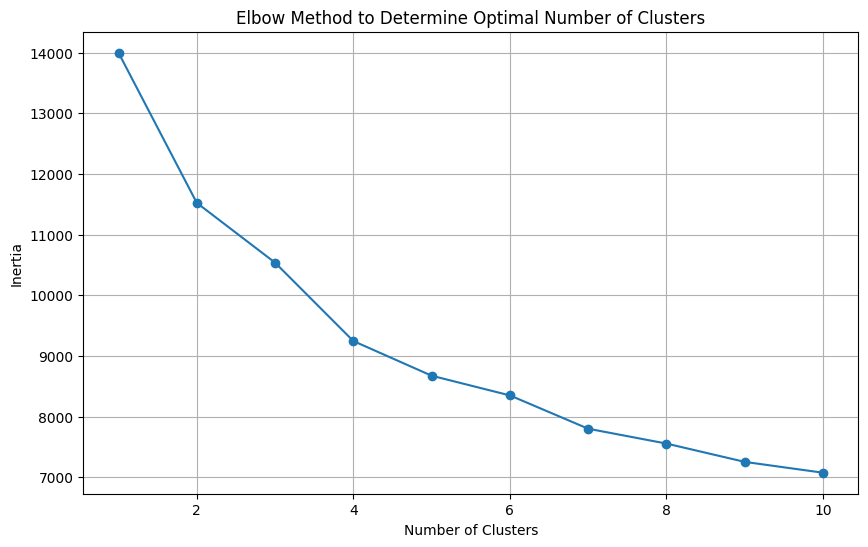

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_values, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method to Determine Optimal Number of Clusters")
plt.grid(True)
plt.show()

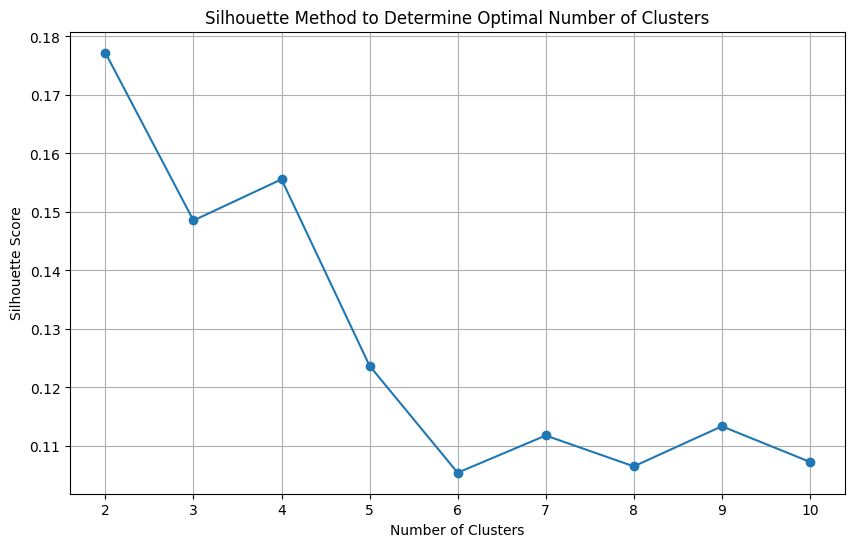

In [ ]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Plotting Silhouette Scores for Different Values of K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method to Determine Optimal Number of Clusters")
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the original dataset
cluster_names = {
    0: "Low Risk Home Loans",
    1: "High Income Auto Loans",
    2: "Moderate Risk Personal Loans",
    3: "Education Loans with Coapplicant",
    4: "Agricultural Loans with High Collateral",
}
dataset["Cluster"] = pd.Series(cluster_labels).replace(cluster_names)

In [ ]:
# Step 6: Visualizing the Clusters (Using PCA to Reduce Dimensions to 2D)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
dataset["PCA1"] = pca_data[:, 0]
dataset["PCA2"] = pca_data[:, 1]

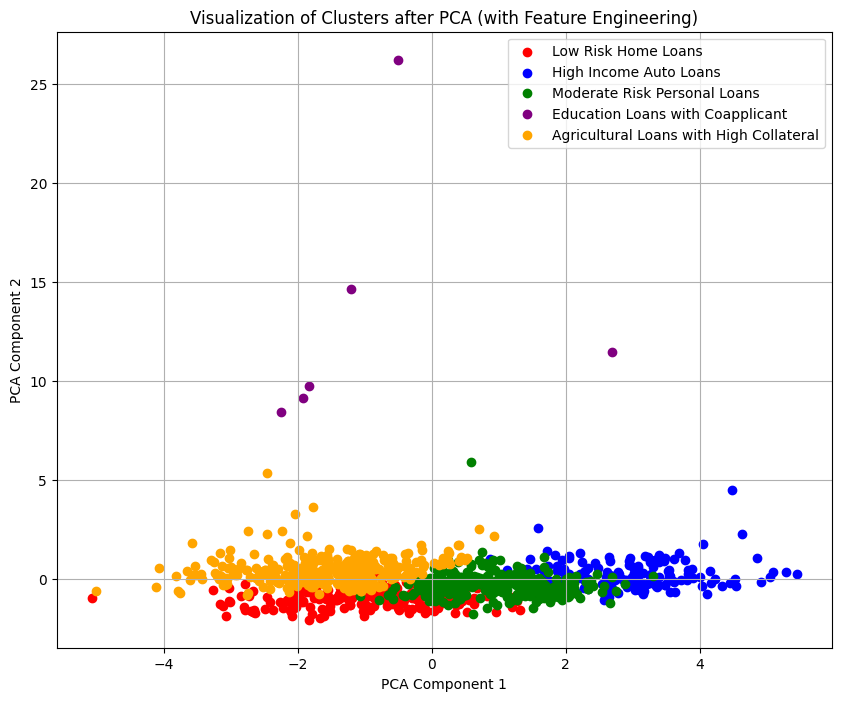

In [ ]:
plt.figure(figsize=(10, 8))
colors = ["red", "blue", "green", "purple", "orange"]
for cluster_name, color in zip(cluster_names.values(), colors):
    cluster_data = dataset[dataset["Cluster"] == cluster_name]
    plt.scatter(
        cluster_data["PCA1"], cluster_data["PCA2"], color=color, label=cluster_name
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualization of Clusters after PCA (with Feature Engineering)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
final_silhouette_score = silhouette_score(scaled_data, cluster_labels)
print(f"Silhouette Score for K=5: {final_silhouette_score:.2f}")

# Step 8: Output the Data Segregation Summary Table
cluster_summary = (
    dataset[["Loan_Type", "Cluster"]]
    .groupby(["Cluster", "Loan_Type"])
    .size()
    .reset_index(name="Count")
)
print(cluster_summary)

# Display the full dataset with cluster information
print(dataset.head())

Silhouette Score for K=5: 0.12
                                    Cluster          Loan_Type  Count
0   Agricultural Loans with High Collateral  Agricultural Loan    159
1   Agricultural Loans with High Collateral          Auto Loan      4
2   Agricultural Loans with High Collateral     Education Loan      8
3   Agricultural Loans with High Collateral          Home Loan    160
4   Agricultural Loans with High Collateral      Personal Loan     16
5          Education Loans with Coapplicant  Agricultural Loan      4
6          Education Loans with Coapplicant          Auto Loan      1
7          Education Loans with Coapplicant          Home Loan      1
8                    High Income Auto Loans  Agricultural Loan      6
9                    High Income Auto Loans          Auto Loan    132
10                   High Income Auto Loans     Education Loan     17
11                   High Income Auto Loans          Home Loan      3
12                   High Income Auto Loans      Personal L